In [32]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
import numpy as np

import sys
sys.path.append('..')
from src.pipeline import *
from src.simple_model import *
from src.numpy_model import *
from src.simple_neural_network_model import *

# Parameters
ticker = "AAPL"
period = "2y"
interval = "1d"
data_path = "../data/aapl.csv"
models=["rf","xgb","lm"]

/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/notebooks/../src/pipeline.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


Data downloaded successfully.
Data saved to ../data/aapl.csv
Model: LogisticRegression
Accuracy: 0.55
Confusion Matrix:
[[15 77]
 [12 94]]
Model: RandomForestClassifier
Accuracy: 0.54
Confusion Matrix:
[[48 44]
 [47 59]]
Model: XGBClassifier
Accuracy: 0.53
Confusion Matrix:
[[48 44]
 [50 56]]
Model: LinearRegression
Mean Squared Error: 0.0005
R^2 Score: -0.0001


/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: RandomForestRegressor
Mean Squared Error: 0.0005
R^2 Score: -0.0202
Model: XGBRegressor
Mean Squared Error: 0.0007
R^2 Score: -0.3821
Model: RandomForestClassifier


/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


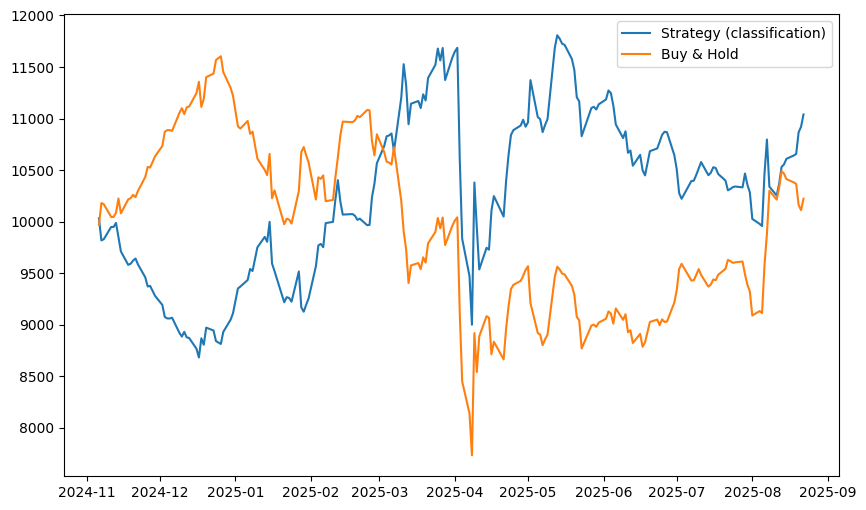

Model: XGBClassifier


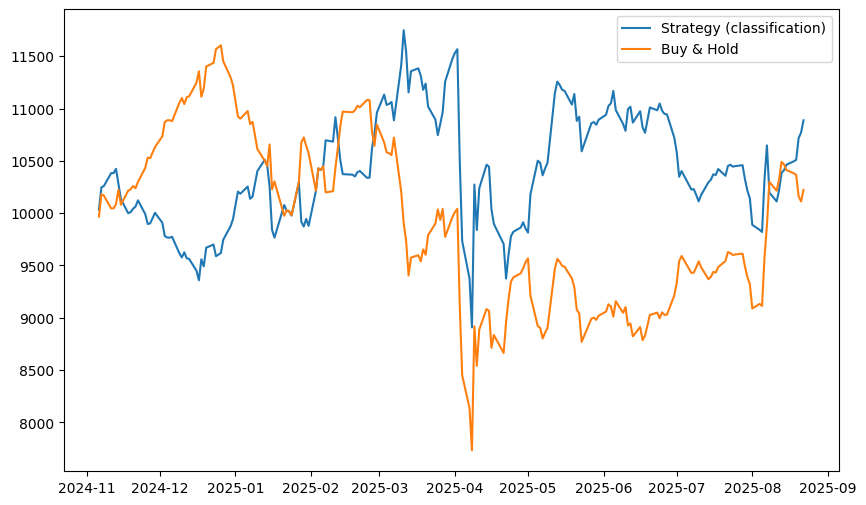

Model: LogisticRegression


/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


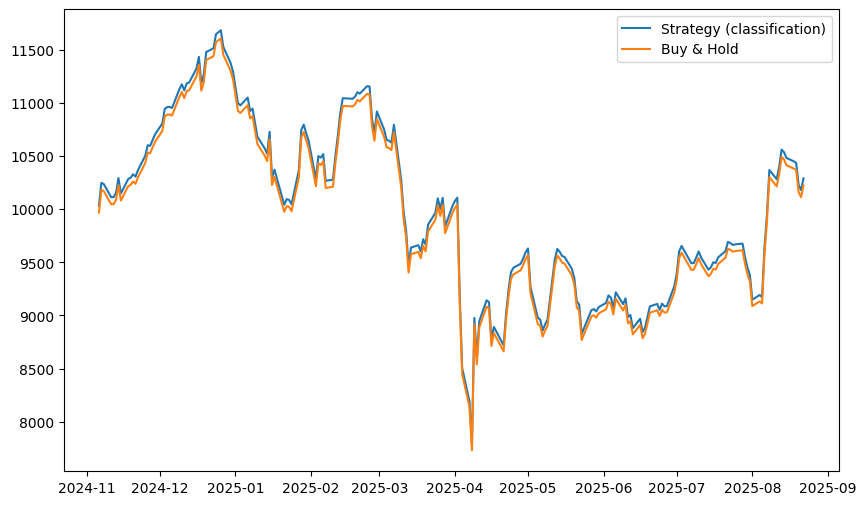

Model: RandomForestRegressor


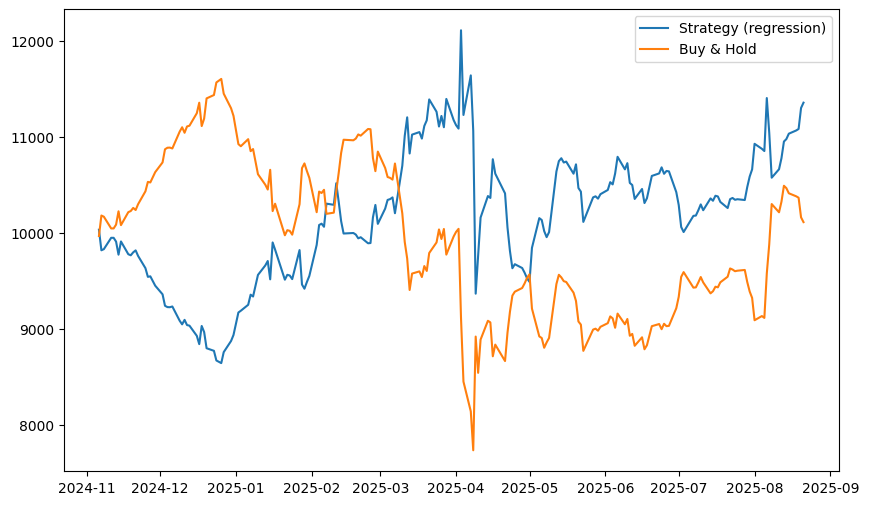

Model: XGBRegressor


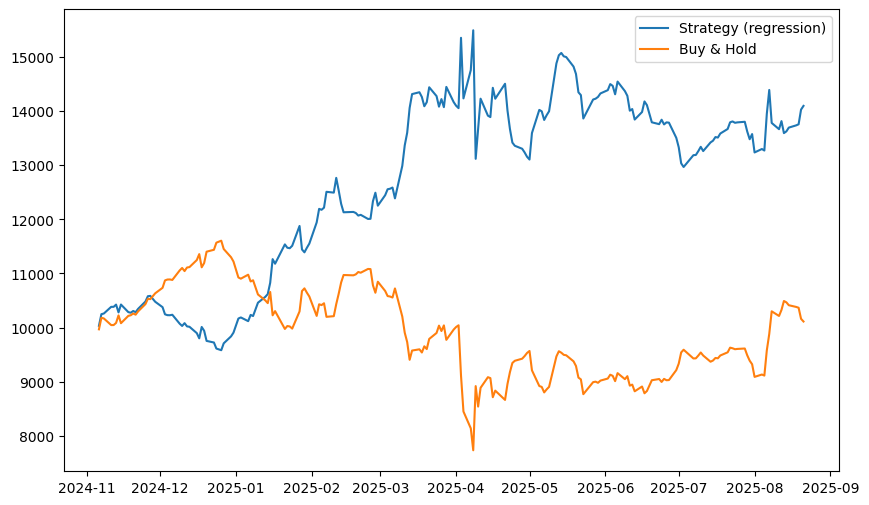

Model: LinearRegression


/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


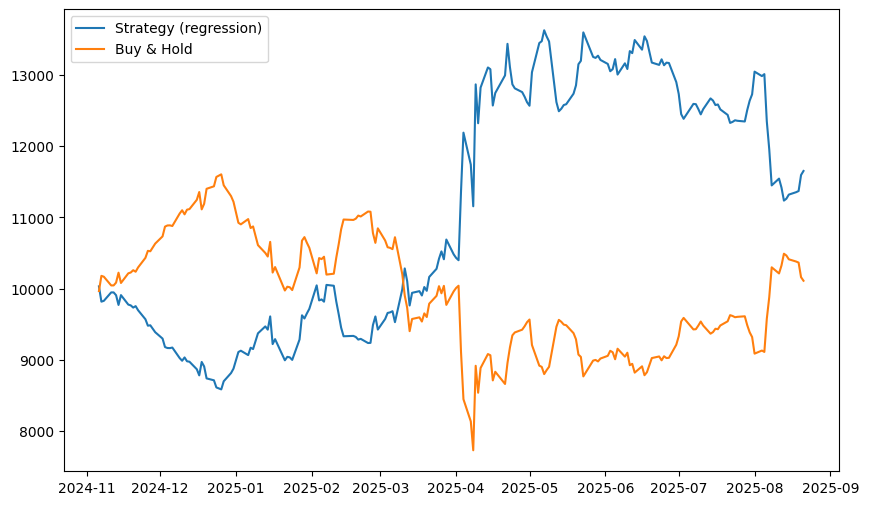

ValueError: Length mismatch: Expected axis has 197 elements, new values have 198 elements

In [ ]:
#run_pipeline(ticker, period, interval, data_path, models)
run_pipeline("AAPL", extra_models=[simple_model_class(),numpy_model_reg(),simple_MLP_regressor()])

In [ ]:
# Download Data
# if not os.path.exists(data_path):
#     print(f"Downloading data for {ticker}...")
#     data = yf.download(ticker, period=period, interval=interval)
    
#     if isinstance(data.columns, pd.MultiIndex):
#             data.columns = data.columns.get_level_values(0)
#     print("Data downloaded successfully.")
# else:
#     print(f"Data for {ticker} already exists at {data_path}. Loading from file.")
#     data = pd.read_csv(data_path, index_col='Date', parse_dates=True)

data = load_data(ticker,period,interval,data_path)


Data for AAPL already exists at ../data/aapl.csv. Loading from file.


In [ ]:
create_flags(data)

In [ ]:
# # Create Lagged Returns
# data['Returns'] = data['Close'].pct_change()

# # creates lagged returns for specified lags
# lags  = [1,2,3,5]
# for lag in lags:
#     data[f'Lagged_Returns_{lag}'] = data['Returns'].shift(lag)

In [ ]:
# # Create Moving Averages
# MA_periods = [5, 20, 100]
# for period in MA_periods:
#     data[f"MA_{period}"] = data['Close'].rolling(window = period).mean()

# # Create Moving Average Crossover
# #data['MA_Crossover_5_20'] = (data['MA_5'] > data['MA_20']).astype(int)

In [ ]:
# Create Momentum 
# Hurt accuracy
momentum_periods = [5,10, 20]
for period in momentum_periods:
    data[f'Momentum_{period}'] = data['Close'].diff(periods=period)

In [ ]:
# Create Rate of Change (ROC)
# Hurt accuracy
roc_periods = [5, 10, 20]
for period in roc_periods:
    data[f'ROC_{period}'] = data['Close'].pct_change(periods=period)

In [ ]:
# # Create RSI
# delta = data['Close'].diff()
# gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
# loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
# rs = gain / loss
# data['RSI'] = 100 - (100 / (1 + rs))

In [ ]:
# # Create MACD
# ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
# ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
# data['MACD'] = ema_12 - ema_26
# data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
# data['MACD_Hist'] = data['MACD'] - data['Signal_Line']

In [ ]:
# # Create Bollinger Bands 
# sma_20 = data['Close'].rolling(window=20).mean()
# upper_band = sma_20 + 2 * data['Close'].rolling(window=20).std()
# lower_band = sma_20 - 2 * data['Close'].rolling(window=20).std()
# data['Upper_Band'] = upper_band
# data['Lower_Band'] = lower_band

In [ ]:
# # Create Volatility
# vol_windows = [10, 20, 60]
# for window in vol_windows:
#     data[f'Volatility_{window}'] = data['Close'].rolling(window=window).std()

In [ ]:
# # Create Target Variable
# data['Target_Classification'] = (data['Returns'].shift(-1) > 0).astype(int)
# data['Target_Regression'] = data['Returns'].shift(-1) 

In [ ]:
# Save to CSV
data.to_csv(data_path)
print(f"Data saved to {data_path}")

Data saved to ../data/aapl.csv


In [ ]:
# # Create X and Y
# x_unclean = data[['Lagged_Returns_1', 'Lagged_Returns_2', 'Lagged_Returns_3', 'Lagged_Returns_5',
#               'MA_5', 'MA_20', 'RSI', 'MACD', 'Signal_Line', 'MACD_Hist',
#               'Upper_Band', 'Lower_Band', 'Volatility_10', 'Volatility_20']]
# y_unclean_classification = data['Target_Classification']
# y_unclean_regression = data['Target_Regression']

# combined_classification = pd.concat([x_unclean, y_unclean_classification.rename('Target')], axis=1).dropna()
# combined_regression = pd.concat([x_unclean, y_unclean_regression.rename('Target')], axis=1).dropna()

# x_clean_classification = combined_classification.drop(columns=['Target'],axis=1)
# y_clean_classification = combined_classification['Target']
# x_clean_regression = combined_regression.drop(columns=['Target'], axis=1)
# y_clean_regression = combined_regression['Target']

x_clean_classification, y_clean_classification, x_clean_regression, y_clean_regression = create_x_y(data)

In [ ]:
# Split Data into Train and Test Sets
#cutoff_date = "2024-07-01"

x_train_class, x_test_class, y_train_class, y_test_class, x_test_class_index, \
    x_train_reg, x_test_reg, y_train_reg, y_test_reg, x_test_reg_index =  \
        split_data(x_clean_classification, y_clean_classification, x_clean_regression, y_clean_regression)

# x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(
#     x_clean_classification, y_clean_classification, test_size=0.2, shuffle=False
# )

# x_test_class_index = x_test_class.index

# x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(
#     x_clean_regression, y_clean_regression, test_size=0.2, shuffle=False
# )

# x_test_reg_index = x_test_reg.index

# x_train = x_clean.loc[:cutoff_date]
# x_test = x_clean.loc[cutoff_date:]

# # Classification

# y_train_class = y_clean_classification.loc[:cutoff_date]
# y_test_class = y_clean_classification.loc[cutoff_date:]

# # Regression
# y_train_reg = y_clean_regression.loc[:cutoff_date]
# y_test_reg = y_clean_regression.loc[cutoff_date:]

In [ ]:
# Baseline Model: Logistic Regression (Classification)
# model = LogisticRegression(max_iter=1000)
# scaler = StandardScaler()
# x_train_class = scaler.fit_transform(x_train_class)
# x_test_class = scaler.transform(x_test_class)
# model.fit(x_train_class, y_train_class)
# predictions = model.predict(x_test_class)
# accuracy = accuracy_score(y_test_class, predictions)
# conf_matrix = confusion_matrix(y_test_class, predictions)

# print(f"Accuracy: {accuracy}")
# print("Confusion Matrix:\n", conf_matrix)
# print(y_train_class.value_counts(normalize=True))

rf_classifier, xgb_classifier, lm_classifier = classification_model(x_train_class, x_test_class, y_train_class, y_test_class)
classification_models = [rf_classifier, xgb_classifier, lm_classifier]

Model: LogisticRegression
Accuracy: 0.57
Confusion Matrix:
[[16 28]
 [14 39]]
Model: RandomForestClassifier
Accuracy: 0.59
Confusion Matrix:
[[12 32]
 [ 8 45]]
Model: XGBClassifier
Accuracy: 0.61
Confusion Matrix:
[[17 27]
 [11 42]]


/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Baseline Model: Linear Regression (Regression)
# model_reg = LinearRegression()
# x_train_reg = scaler.fit_transform(x_train_reg)
# x_test_reg = scaler.transform(x_test_reg)
# model_reg.fit(x_train_reg, y_train_reg)
# y_pred_reg = model_reg.predict(x_test_reg)
# mse = mean_squared_error(y_test_reg, y_pred_reg)
# r2 = r2_score(y_test_reg, y_pred_reg)
# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

rf_regressor, xgb_regressor, lm_regressor = regression_model(x_train_reg, x_test_reg, y_train_reg, y_test_reg)
regression_models = [rf_regressor, xgb_regressor, lm_regressor]

Model: LinearRegression
Mean Squared Error: 0.0007
R^2 Score: 0.0036
Model: RandomForestRegressor
Mean Squared Error: 0.0007
R^2 Score: 0.0155
Model: XGBRegressor
Mean Squared Error: 0.0007
R^2 Score: 0.0423


/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Random Forest Classifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(x_train_class, y_train_class)

# y_pred = rf_model.predict(x_test_class)

# print("Accuracy:", accuracy_score(y_test_class, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred))

In [ ]:
# Random Forest Regression
# rf_model_reg = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model_reg.fit(x_train_reg, y_train_reg)

# y_pred = rf_model_reg.predict(x_test_reg)
# mse_reg = mean_squared_error(y_test_reg, y_pred)
# r2_reg = r2_score(y_test_reg, y_pred)
# print(f"Random Forest Regression Mean Squared Error: {mse_reg}")
# print(f"Random Forest Regression R^2 Score: {r2_reg}")

In [ ]:
# XGBoost Classifier

# xbg_model = XGBClassifier(eval_metric='logloss')

# xbg_model.fit(x_train_class, y_train_class)

# y_pred_xbg = xbg_model.predict(x_test_class)

# print("XGBoost Accuracy:", accuracy_score(y_test_class, y_pred_xbg))
# print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_xbg))

In [ ]:
# XGBoost Regression
# xbg_model_reg = XGBRegressor(eval_metric='rmse')

# xbg_model_reg.fit(x_train_reg, y_train_reg)

# y_pred_xbg_reg = xbg_model_reg.predict(x_test_reg)
# mse_xbg_reg = mean_squared_error(y_test_reg, y_pred_xbg_reg)
# r2_xbg_reg = r2_score(y_test_reg, y_pred_xbg_reg)
# print(f"XGBoost Regression Mean Squared Error: {mse_xbg_reg}")
# print(f"XGBoost Regression R^2 Score: {r2_xbg_reg}")

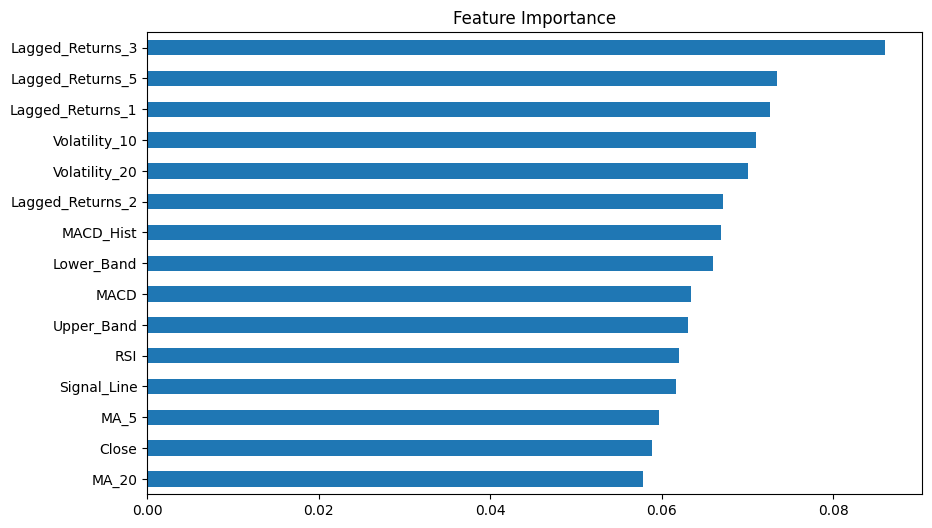

In [ ]:
# Show feature importance
importances = pd.Series(rf_classifier.feature_importances_, index=x_clean_classification.columns)
importances.sort_values().plot(kind="barh", figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

In [ ]:
# Basic Exploration
print(data.head())

                 Close        High         Low        Open    Volume  \
Date                                                                   
2023-08-14  177.719269  177.947034  175.590114  176.243716  43675600   
2023-08-15  175.728729  177.739037  175.332615  177.144866  43622600   
2023-08-16  174.857285  176.808162  174.787956  175.411850  46964900   
2023-08-17  172.312210  175.788158  171.797250  175.421752  66062900   
2023-08-18  172.797485  173.401569  170.292027  170.628726  61172200   

             Returns  Lagged_Returns_1  Lagged_Returns_2  Lagged_Returns_3  \
Date                                                                         
2023-08-14       NaN               NaN               NaN               NaN   
2023-08-15 -0.011200               NaN               NaN               NaN   
2023-08-16 -0.004959         -0.011200               NaN               NaN   
2023-08-17 -0.014555         -0.004959         -0.011200               NaN   
2023-08-18  0.002816       

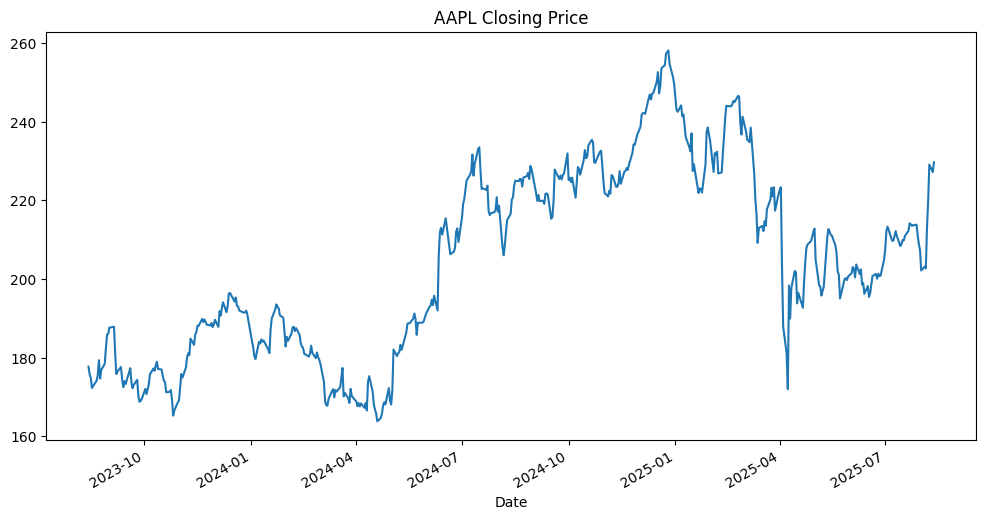

In [ ]:
# Plot Close price
plt.figure(figsize=(12,6))
data['Close'].plot(title=f"{ticker} Closing Price")
plt.show()

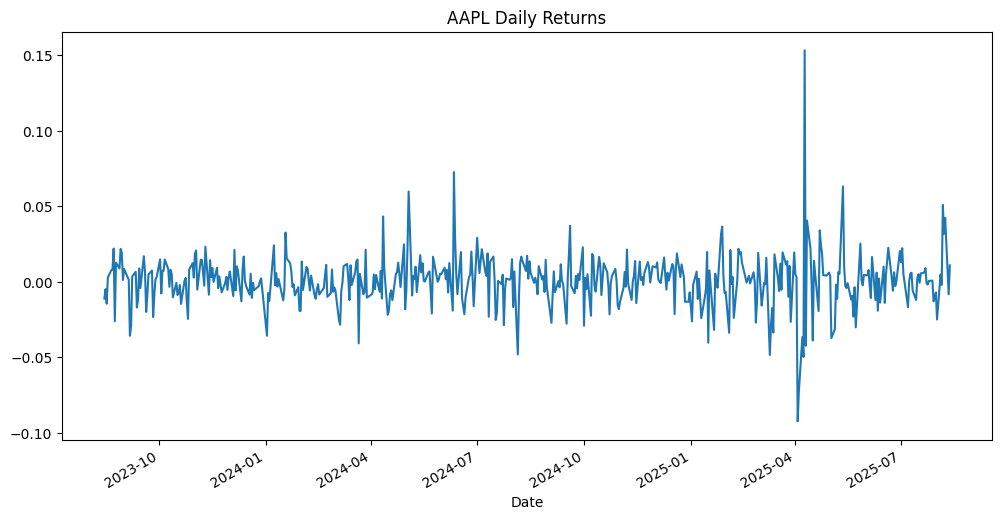

In [ ]:
# Calculate daily returns and plot
data['Returns'] = data['Close'].pct_change()
plt.figure(figsize=(12,6))
data['Returns'].plot(title=f"{ticker} Daily Returns")
plt.show()

Model: RandomForestClassifier


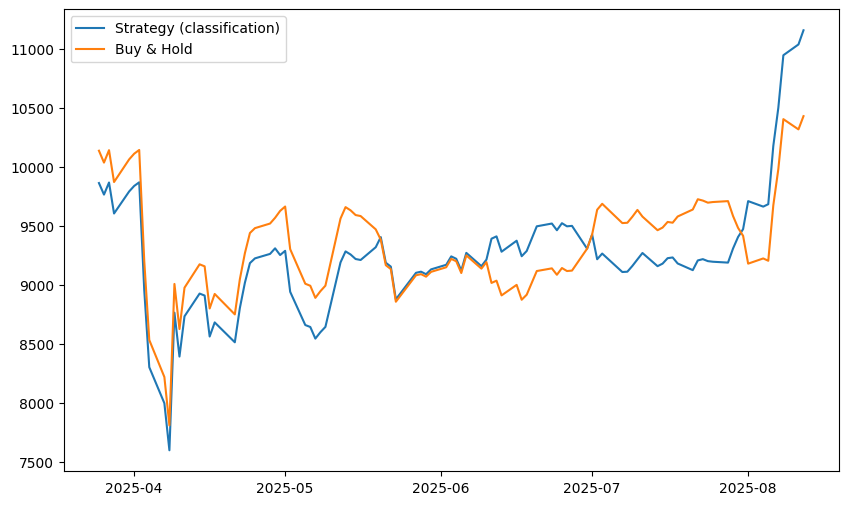

Model: XGBClassifier


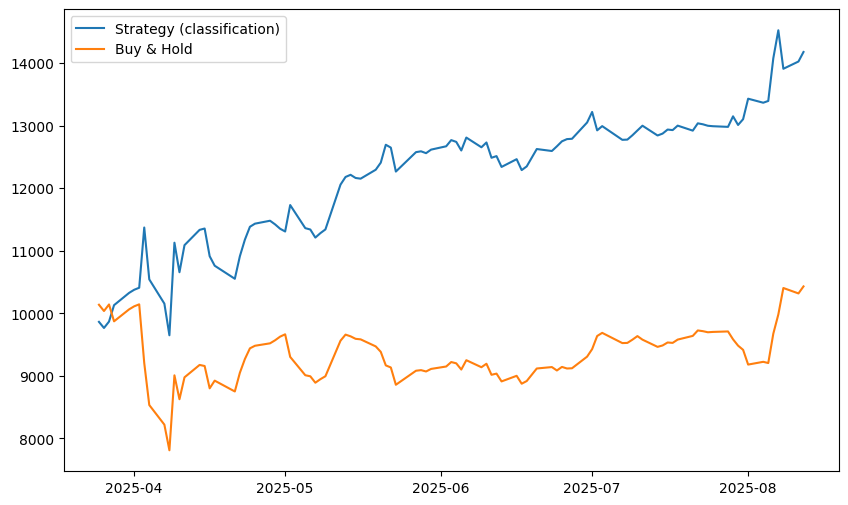

Model: LogisticRegression


/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


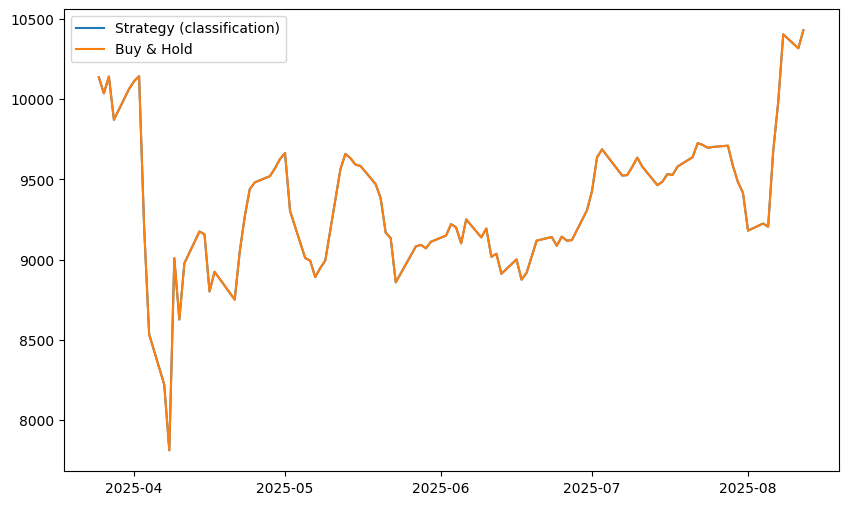

In [ ]:
# Backtesting Classification
# y_pred_class = model.predict(x_test_class)

# signals_class = pd.Series(y_pred_class, index=x_test_class_index)

# signals_class = signals_class.shift(1).fillna(0)

# returns = data['Returns'].loc[x_test_class_index] 

# strategy_returns_class = signals_class * returns

# initial_capital = 10000

# portfolio_class = (strategy_returns_class + 1).cumprod() * initial_capital

# buy_hold = (returns + 1).cumprod() * initial_capital

# plt.figure(figsize=(10,6))
# plt.plot(portfolio_class, label="Strategy (Classification)")
# plt.plot(buy_hold, label="Buy & Hold")
# plt.legend()
# plt.show()

portfolio_class = []

for model in classification_models:
    print(f"Model: {model.__class__.__name__}")
    #backtesting_classification(data, model, x_test_class, x_test_class_index)
    portfolio_class.append(backtest_strategy(data, model, x_test_class, x_test_class_index))

Model: RandomForestRegressor


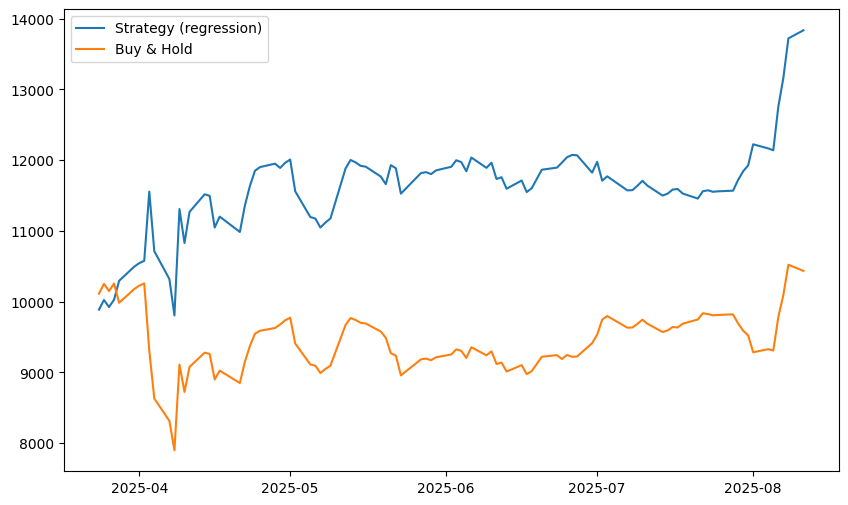

Model: XGBRegressor


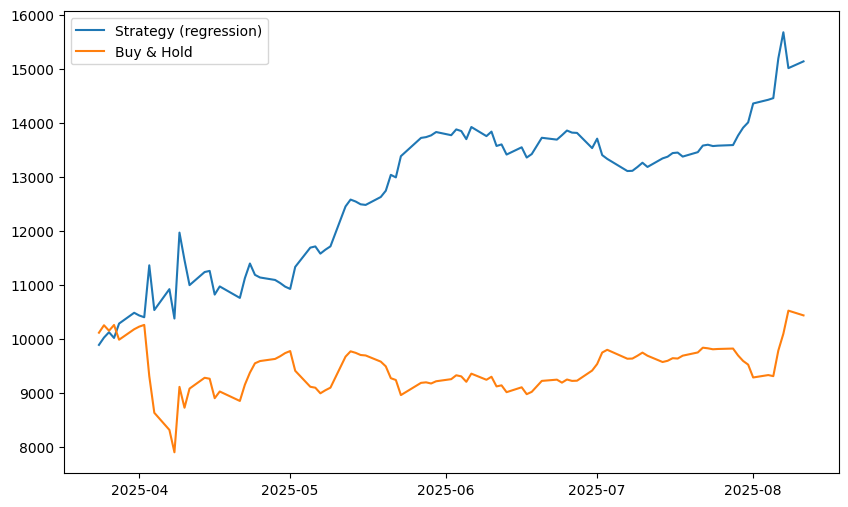

Model: LinearRegression


/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


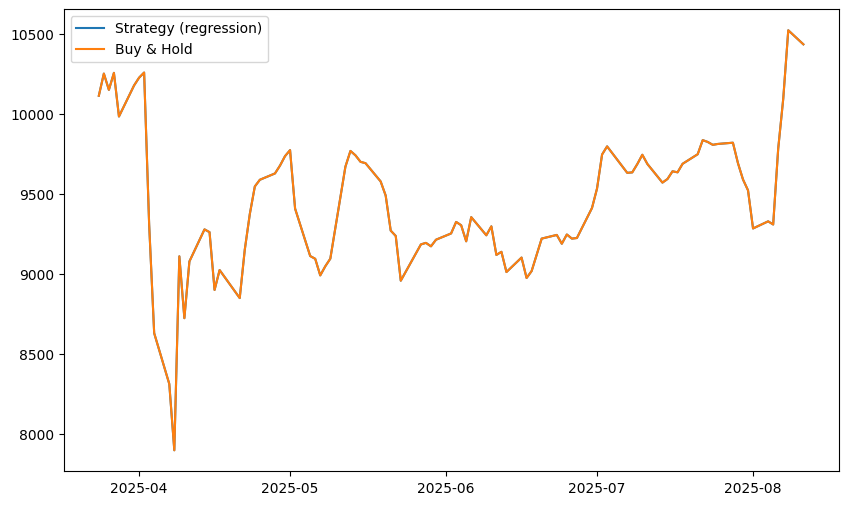

In [ ]:
# Backtesting Regression
# y_pred_reg = model_reg.predict(x_test_reg)

# signals_reg = pd.Series((y_pred_reg > 0).astype(int), index=x_test_reg_index)

# signals_reg = signals_reg.shift(1).fillna(0)

# returns = data['Returns'].loc[x_test_reg_index] 

# strategy_returns_reg = signals_reg * returns

# initial_capital = 10000

# portfolio_reg = (strategy_returns_reg + 1).cumprod() * initial_capital

# buy_hold = (returns + 1).cumprod() * initial_capital

# plt.figure(figsize=(10,6))
# plt.plot(portfolio_reg, label="Strategy (Regression)")
# plt.plot(buy_hold, label="Buy & Hold")
# plt.legend()
# plt.show()

portfolio_reg = []

for model in regression_models:
    print(f"Model: {model.__class__.__name__}")
    #backtesting_regression(data, model, x_test_reg, x_test_reg_index)
    portfolio_reg.append(backtest_strategy(data, model, x_test_reg, x_test_reg_index, 'regression'))

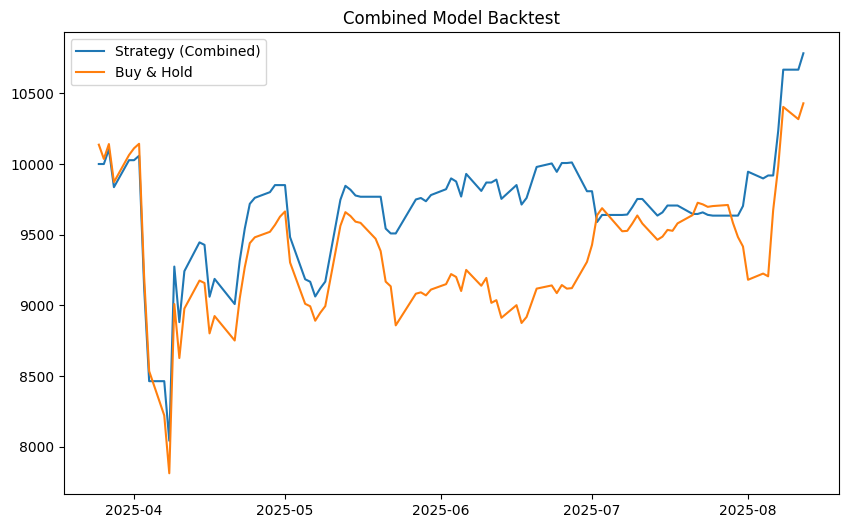

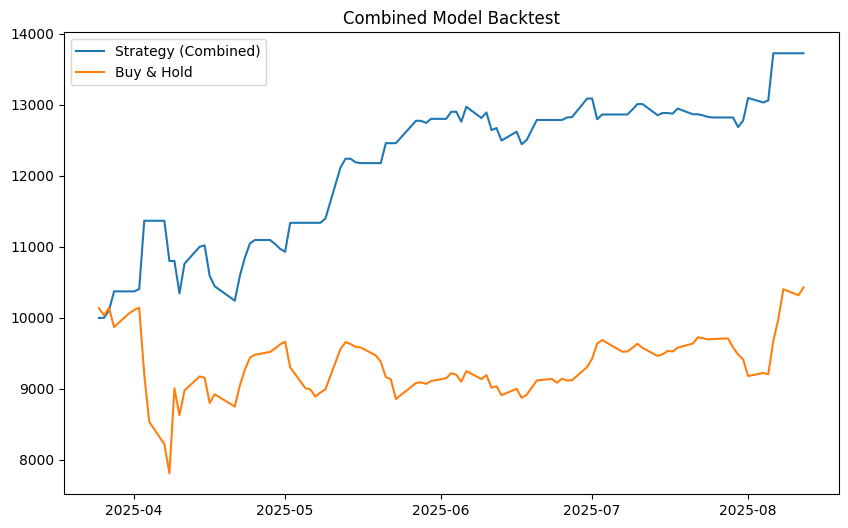

/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/shiv/Desktop/Stock-ml-predictor/stock-ml-predictor/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


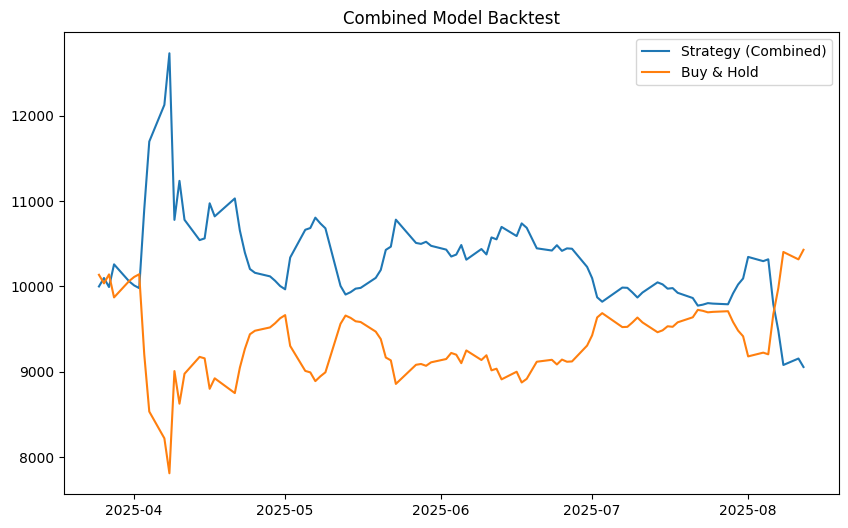

In [ ]:
# Backtesting Combined

# y_pred_class = model.predict(x_test_class)  # Your trained classification model
# signals_class = pd.Series(y_pred_class, index=x_test_class_index)

# signals_class = signals_class.replace(0, -1)
# signals_reg_direction = signals_reg.apply(lambda x: 1 if x > 0 else -1)

# signals_reg_direction.index = signals_class.index

# combined_signals = np.where(signals_class == signals_reg_direction, signals_class, 0)
# combined_signals = pd.Series(combined_signals, index=x_test_class_index)

# combined_signals = combined_signals.shift(1).fillna(0)

# returns = data['Returns'].loc[combined_signals.index]
# strategy_returns_combined = combined_signals * returns

# initial_capital = 10000
# portfolio_combined = (strategy_returns_combined + 1).cumprod() * initial_capital
# buy_hold = (returns + 1).cumprod() * initial_capital

# plt.figure(figsize=(10,6))
# plt.plot(portfolio_combined, label="Strategy (Combined)")
# plt.plot(buy_hold, label="Buy & Hold")
# plt.legend()
# plt.title("Combined Model Backtest")
# plt.show()

portfolio_combined = []

for model_class, model_reg in zip(classification_models, regression_models):
    portfolio_combined.append(backtesting_combined(model_class, model_reg, x_test_class, x_test_class_index, x_test_reg, x_test_reg_index, data))


In [ ]:
# # Calculate Sharpe Ratio

# def sharpe_ratio(portfolio_values):
#     daily_returns = portfolio_values.pct_change().dropna()
#     return (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

# # Calculate Maximum Drawdown

# def max_drawdown(portfolio_values):
#     cumulative_max = portfolio_values.cummax()
#     drawdown = (portfolio_values - cumulative_max) / cumulative_max
#     return drawdown.min()

# # Calculate Win Rate

# def win_rate(portfolio_values):
#     daily_returns = portfolio_values.pct_change().dropna()
#     wins = (daily_returns > 0).sum()
#     total = len(daily_returns)
#     return wins / total

# sharpe_class = sharpe_ratio(portfolio_class)
# sharpe_reg = sharpe_ratio(portfolio_reg)
# sharpe_combined = sharpe_ratio(portfolio_combined)

# print("Sharpe - Classification:", sharpe_class)
# print("Sharpe - Regression:", sharpe_reg)
# print("Sharpe - Combined:", sharpe_combined)

# mdd_class = max_drawdown(portfolio_class)
# mdd_reg = max_drawdown(portfolio_reg)
# mdd_combined = max_drawdown(portfolio_combined)

# print("Max Drawdown - Classification:", mdd_class)
# print("Max Drawdown - Regression:", mdd_reg)
# print("Max Drawdown - Combined:", mdd_combined)

# win_class = win_rate(portfolio_class)
# win_reg = win_rate(portfolio_reg)
# win_combined = win_rate(portfolio_combined)

# print("Win Rate - Classification:", win_class)
# print("Win Rate - Regression:", win_reg)
# print("Win Rate - Combined:", win_combined)

for i in range(len(models)):
    model_metrics(models[i], portfolio_class[i], portfolio_reg[i], portfolio_combined[i])

Model: rf
Sharpe - Classification: 0.9600655315113593
Sharpe - Regression: 2.2698822206556235
Sharpe - Combined: 0.6812894477153029
Max Drawdown - Classification: -0.22988976997242894
Max Drawdown - Regression: -0.15143464071575025
Max Drawdown - Combined: -0.2041763269610342
Win Rate - Classification: 0.59375
Win Rate - Regression: 0.6041666666666666
Win Rate - Combined: 0.4583333333333333
Model: xgb
Sharpe - Classification: 2.439255500026316
Sharpe - Regression: 2.8377721654316876
Sharpe - Combined: 2.987780362568642
Max Drawdown - Classification: -0.15143464071574997
Max Drawdown - Regression: -0.10103622739822514
Max Drawdown - Combined: -0.09902892283246309
Win Rate - Classification: 0.6041666666666666
Win Rate - Regression: 0.6041666666666666
Win Rate - Combined: 0.3854166666666667
Model: lm
Sharpe - Classification: 0.38253438911024384
Sharpe - Regression: 0.3994312750506957
Sharpe - Combined: -0.3825343891102474
Max Drawdown - Classification: -0.229889769972429
Max Drawdown - Re

In [ ]:
# Check for missing data
missing = data.isnull().sum()
print("Missing data per column:\n", missing)

Missing data per column:
 Close                     0
High                      0
Low                       0
Open                      0
Volume                    0
Returns                   1
Lagged_Returns_1          2
Lagged_Returns_2          3
Lagged_Returns_3          4
Lagged_Returns_5          6
MA_5                      4
MA_20                    19
MA_100                   99
Momentum_5                5
Momentum_10              10
Momentum_20              20
ROC_5                     5
ROC_10                   10
ROC_20                   20
RSI                      13
MACD                      0
Signal_Line               0
MACD_Hist                 0
Upper_Band               19
Lower_Band               19
Volatility_10             9
Volatility_20            19
Volatility_60            59
Target_Classification     0
Target_Regression         1
dtype: int64
